## IMPORT

In [2]:
import pandas as pd
import matplotlib.pyplot  as plt
import os
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.cluster import DBSCAN

In [3]:
from google.colab import drive
drive.mount('/content/drive')
players_dir = '/content/drive/MyDrive/Cricket Related Data/PLAYERS'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## CRUNCHING DATA

In [4]:
def player_cruncher(players_dir,verbose=1,min_matches=10):
  cols = ['player','matches','wickets','runs_scored','balls_faced','fours_count','sixes_count','batting_avg','strike_rate','boundary_pcntg']
  players_df = pd.DataFrame(columns = cols)
  players = os.listdir(players_dir)
  if verbose==1:
    print("No. players found:\t"+str(len(players)))
    print()
  for i in players:
    try:
      df = pd.read_csv(os.path.join(players_dir,i))
      if df.shape[0]==0 or df['match_id'].unique().shape[0] < min_matches:
        continue
      else:
        # print(df['match_id'].unique())
        sum = df[df.columns[-5:]].sum()
        # print(sum)
        dic = {'player':i[:-4],'matches':df['match_id'].unique().shape[0]}
        for k in range(len(cols[2:7])):
          dic[cols[k+2]]=sum[k]
        dic['batting_avg'] = round(dic['runs_scored']/dic['wickets'],2)
        dic['strike_rate'] = round(dic['runs_scored']/dic['balls_faced']*100,2)
        dic['boundary_pcntg'] = round((4*dic['fours_count'] + 6*dic['sixes_count'])/dic['runs_scored']*100,2)
        players_df = players_df.append(dic,ignore_index=True)
    except Exception as e:
      print(e)#(i[:-4])+
    if verbose==2:
      print(i[:-4])
    # break
  if verbose==1:
    print("\nNo. players crunched:\t"+str(players_df.shape[0]))
    print("Uncrunchable:\t"+str(len(players)-players_df.shape[0]))
  return players_df

In [5]:
players_df = player_cruncher(players_dir)
players_df.head(35)

No. players found:	783


No. players crunched:	354
Uncrunchable:	429


,player,matches,wickets,runs_scored,balls_faced,fours_count,sixes_count,batting_avg,strike_rate,boundary_pcntg
0,DA Warner,130,101,4459,4783,483,67,44.15,93.23,52.34
1,SPD Smith,111,69,3184,3747,271,34,46.14,84.97,40.45
2,MS Wade,80,47,1238,1561,91,21,26.34,79.31,39.58
3,Azhar Ali,51,28,1266,1785,115,7,45.21,70.92,39.65
4,Sharjeel Khan,24,17,586,505,77,20,34.47,116.04,73.04
5,Babar Azam,89,58,3250,3783,288,31,56.03,85.91,41.17
6,Umar Akmal,106,68,2113,2469,181,31,31.07,85.58,43.07
7,Mohammad Rizwan,42,28,730,885,55,5,26.07,82.49,34.25
8,UT Khawaja,38,29,1133,1383,108,12,39.07,81.92,44.48
9,Asad Shafiq,56,43,846,1347,68,4,19.67,62.81,34.99


In [6]:
players_df.describe()

,batting_avg,strike_rate,boundary_pcntg
count,354.000000,354.000000,354.000000
mean,30.705989,77.918079,46.527119
std,10.111848,13.436272,8.859738
min,4.670000,41.150000,12.500000
25%,23.222500,68.735000,40.827500
50%,30.225000,76.545000,46.605000
75%,37.022500,86.275000,52.490000
max,62.620000,126.290000,73.040000


## EXPLORATORY PLOTS

In [7]:
def histogram(players_df,att='matches'):
  sns.displot(players_df[att],kde=True)
  plt.title('Distribution of '+att)
  plt.show()

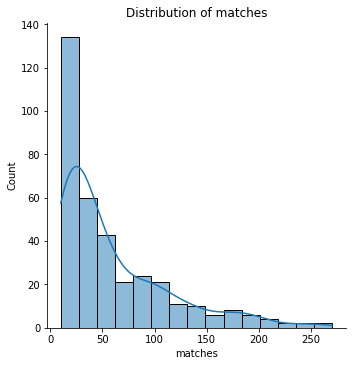

In [8]:
histogram(players_df)

In [9]:
def scatter_plot(players_df,att1='runs_scored',att2='wickets',revert=False):
  if revert:
    att1,att2 = att2,att1
  sns.scatterplot(data=players_df, x=att1, y=att2)
  plt.title(att1+' vs '+att2)
  plt.show()

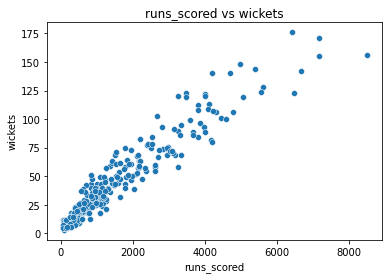

In [10]:
scatter_plot(players_df)

## SCALING DATA

In [11]:
def scaler(players_df,function=1):
  if function==1:
    scaler = StandardScaler()
  elif function==0:
    scaler = MinMaxScaler()
  else:
    scaler = function
  return pd.DataFrame(scaler.fit_transform(players_df),columns=players_df.columns)

In [12]:
scaled_df = scaler(players_df.set_index('player'))
scaled_df.head(35)

,matches,wickets,runs_scored,balls_faced,fours_count,sixes_count,batting_avg,strike_rate,boundary_pcntg
0,1.321567,1.811049,2.198263,1.847115,2.488780,1.842977,1.331412,1.141209,0.657029
1,0.965927,0.888960,1.309866,1.241713,1.013813,0.559463,1.528490,0.525585,-0.686896
2,0.385673,0.255023,-0.046072,-0.035709,-0.238517,0.053837,-0.432381,0.103741,-0.785232
3,-0.157146,-0.292467,-0.026562,0.095189,-0.071539,-0.490684,1.436388,-0.521572,-0.777320
4,-0.662528,-0.609435,-0.500374,-0.652799,-0.335920,0.014942,0.372765,2.841255,2.996749
5,0.554134,0.571992,1.355853,1.262750,1.132089,0.442780,2.507935,0.595644,-0.605515
6,0.872338,0.860145,0.563612,0.494894,0.387648,0.442780,0.036049,0.571049,-0.390758
7,-0.325606,-0.292467,-0.400038,-0.430740,-0.488983,-0.568473,-0.459120,0.340749,-1.387682
8,-0.400478,-0.263652,-0.119234,-0.139726,-0.120241,-0.296212,0.828320,0.298266,-0.231386
9,-0.063556,0.139762,-0.319211,-0.160763,-0.398537,-0.607367,-1.092937,-1.126016,-1.304040


## CONSTANS & FUNCTION DEFINITIONS

In [13]:
PLAYERS_DF=players_df
SCALED_DF=scaled_df
NUM_CLUSTERS = 4 #6,5,4
CLUSTER_COLS = list(players_df.columns)
CLUSTER_COLORS = ['#F28A30','#0ABDA0','#008AC5','#D6618F','#F3CD05','#A882C1','#BDA589','#888C46',
                  '#36688D','#00743F','#0444BF','#A7414A','#1D65A6','red','green','blue','orange','pink','yellow']


In [14]:
def slope_dif(k,arr,min_k=2):
  if k==min_k:
    print("error: min_k")
  else:
    k=k-min_k
    res = round(abs(arr[k+1]-2*arr[k]+arr[k-1]),4)
    print(f"{k+min_k} : {res}")

In [15]:
# RESULTS

#//don't compeletely understand myself

def  summary(att,PLAYERS_DF=PLAYERS_DF):
    
    summary_df = pd.DataFrame(PLAYERS_DF[att].value_counts().sort_index())
    summary_df.columns = ['players']
    summary_df.insert(0, 'Cluster', summary_df.index)
    

    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    summary_df['players'].plot.pie(autopct="%1.1f%%",  colors = CLUSTER_COLORS)
    
    print("\n-----------------------\nPLAYERS CLUSTER SUMMARY\n-----------------------\n")
    
    ax2 = fig.add_subplot(122)
    font_size=14
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    colors = []
    num_columns = len(summary_df.columns)
    num_rows = len(summary_df.index)
    for i in range(num_rows):
        colors.append([CLUSTER_COLORS[i]] * num_columns)

    summary_plot_table = ax2.table(cellText=summary_df.values,cellColours=colors,
                         colLabels=summary_df.columns,bbox=bbox,loc='center',cellLoc='center' )

    summary_plot_table.auto_set_font_size(False)
    summary_plot_table.set_fontsize(font_size)

    plt.show()

def  clustered_data(att,PLAYERS_DF=PLAYERS_DF):
    grouper = PLAYERS_DF.sort_values(["matches"], ascending = False)[['player',att]].groupby([att])
    cluster_df = pd.concat([pd.Series(v['player'].tolist(), name=k) for k, v in grouper], axis=1)
    cluster_df.fillna('',inplace=True)
    print("\n-----------------------\nPLAYERS IN EACH CLUSTER\n-----------------------\n")
    
    def print_with_column_color_style(input_df):
      col_bgcolor_dict = dict(zip(input_df.columns,['background-color:'+i for i in CLUSTER_COLORS]))
      def mycolor(x):
          return pd.DataFrame(col_bgcolor_dict,index=x.index,columns=x.columns)

      return input_df.style.apply(mycolor,axis=None)

    display(print_with_column_color_style(cluster_df))
    # display(cluster_df)
    # return cluster_df

#//don't compeletely understand myself

In [16]:
def kmeans(ip_df=SCALED_DF,op_df=PLAYERS_DF,k=NUM_CLUSTERS,min_k=2,max_k=12,elbow_iter=50,silho_iter=300):
    if k:
      kmeans = KMeans(n_clusters=k, max_iter=elbow_iter)
      kmeans.fit(ip_df)
      # assign the label to the output column
      op_df['KMeans_cluster'] = kmeans.labels_
      summary('KMeans_cluster')
      clustered_data('KMeans_cluster')
    else:
      inertia_arr = []

      for k in range(min_k, max_k+1):
          elbow_km = KMeans(n_clusters=k, max_iter=elbow_iter)
          elbow_km.fit(ip_df)
          inertia_arr.append(elbow_km.inertia_)

          silho_km = KMeans(n_clusters=k, max_iter=silho_iter)
          silho_km.fit(ip_df)
          cluster_labels = silho_km.labels_
          silhouette_avg = round(silhouette_score(ip_df, cluster_labels),4)
          print(f"For k={k}, silhouette score = {silhouette_avg}")

      print()
      plt.plot(range(min_k, max_k+1), inertia_arr, 'bx-')
      plt.xlabel('k')
      plt.ylabel('inertia')
      plt.title('Elbow Curve')
      plt.show()
      return inertia_arr

In [17]:
def hierar(linkage_method='complete', linkage_metric='euclidean', num_clusters=NUM_CLUSTERS,input_df=SCALED_DF,output_df=PLAYERS_DF):
    mergings = linkage(input_df, method=linkage_method, metric=linkage_metric)
    cluster_labels = cut_tree(mergings, n_clusters=num_clusters).reshape(-1, )
    output_df['Hierar_cluster'] = cluster_labels
    dendrogram(mergings)
    plt.show()
    summary('Hierar_cluster')
    clustered_data('Hierar_cluster')

In [18]:
def dbscan(epsilon=0.9, minimum_samples=3,input_df=SCALED_DF,output_df=PLAYERS_DF):
    db = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit(input_df)
    labels = db.labels_
    output_df['DBSCAN_cluster'] = labels
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    summary('DBSCAN_cluster')
    clustered_data('DBSCAN_cluster')

## FINDING APT CLUSTER VALUE

For k=2, silhouette score = 0.4845
For k=3, silhouette score = 0.2671
For k=4, silhouette score = 0.268
For k=5, silhouette score = 0.2657
For k=6, silhouette score = 0.2541
For k=7, silhouette score = 0.2301
For k=8, silhouette score = 0.2438
For k=9, silhouette score = 0.241
For k=10, silhouette score = 0.2309
For k=11, silhouette score = 0.2152
For k=12, silhouette score = 0.1998



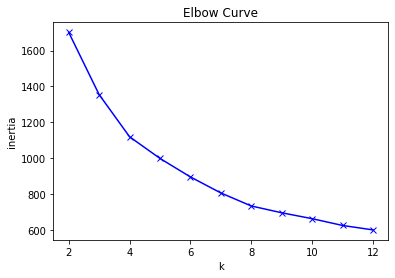

In [19]:
inertia_arr=kmeans(k=0)

In [20]:
slope_dif(4,inertia_arr)
slope_dif(5,inertia_arr)
slope_dif(8,inertia_arr)

4 : 114.0172
5 : 17.8204
8 : 34.665


In [21]:
# # Show the top few players in each cluster (Players sorted on no. of matches played)
# def  groupby_cluster(att, df=PLAYERS_DF, head_size=5):
#     g = PLAYERS_DF.groupby([att]).apply(lambda x: x.sort_values(["matches"], ascending = False)).reset_index(drop=True)
#     # select top N rows within each cluster
#     display(g.groupby(att)['name',att].head(head_size))


In [22]:
# Get the summary of the clustering based on the labels in the output column specified
# def  cluster_all_stats(att): 
#     display(print_with_row_color_style(PLAYERS_DF[CLUSTER_COLS+[att]],att))

## **K MEANS** CLUSTERING


-----------------------
PLAYERS CLUSTER SUMMARY
-----------------------



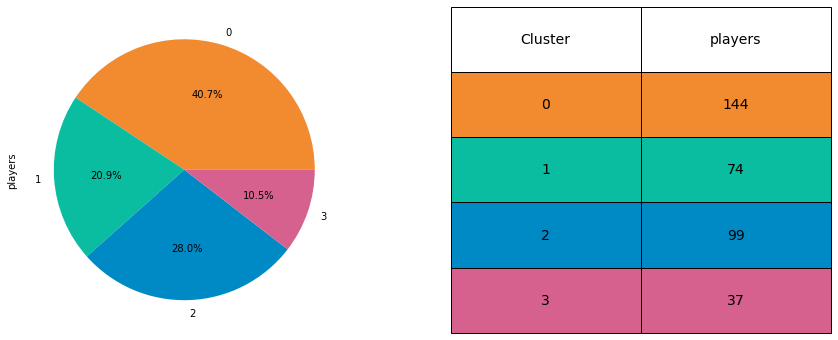


-----------------------
PLAYERS IN EACH CLUSTER
-----------------------



,0,1,2,3
0,CK Kapugedera,Mahmudullah,DJG Sammy,MS Dhoni
1,KD Karthik,Younis Khan,DR Smith,KC Sangakkara
2,NJ O'Brien,MEK Hussey,Najibullah Zadran,TM Dilshan
3,GC Wilson,GC Smith,MR Marsh,V Kohli
4,S Matsikenyeri,MN Samuels,KJ Coetzer,DPMD Jayawardene
5,GD Elliott,Misbah-ul-Haq,DJ Hussey,RG Sharma
6,RD Berrington,LD Chandimal,Liton Das,Tamim Iqbal
7,MN Waller,G Gambhir,Sabbir Rahman,LRPL Taylor
8,MJ Prior,PD Collingwood,JDS Neesham,WU Tharanga
9,Asad Shafiq,JC Buttler,Soumya Sarkar,AB de Villiers


In [23]:
kmeans()

## **HIERARCHICHAL** CLUSTERING

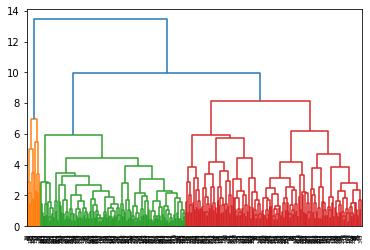


-----------------------
PLAYERS CLUSTER SUMMARY
-----------------------



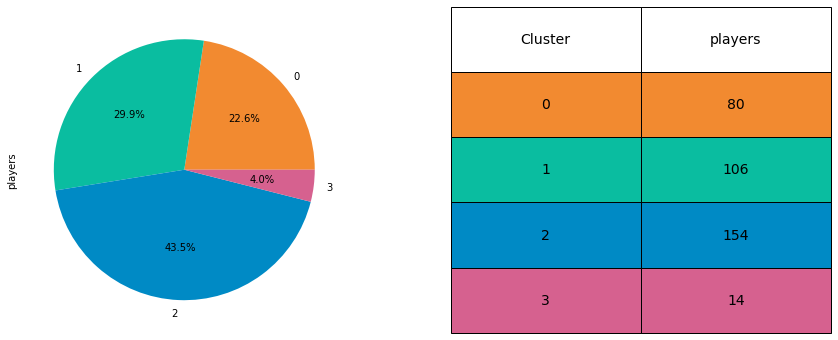


-----------------------
PLAYERS IN EACH CLUSTER
-----------------------



,0,1,2,3
0,Mushfiqur Rahim,D Ramdin,KD Karthik,MS Dhoni
1,MJ Clarke,MV Boucher,S Matsikenyeri,KC Sangakkara
2,Shoaib Malik,Sarfraz Ahmed,DR Smith,TM Dilshan
3,SK Raina,T Taibu,MN Waller,V Kohli
4,Mohammad Hafeez,MS Wade,MJ Prior,DPMD Jayawardene
5,Yuvraj Singh,BKG Mendis,Asad Shafiq,RG Sharma
6,Shakib Al Hasan,Ahmed Shehzad,MH Cross,Tamim Iqbal
7,AD Mathews,Asghar Stanikzai,MF Maharoof,LRPL Taylor
8,Mahmudullah,CK Kapugedera,Aftab Ahmed,WU Tharanga
9,JP Duminy,NJ O'Brien,DR Martyn,AB de Villiers


In [24]:
hierar()

## **DBSCAN** CLUSTERING

Estimated number of clusters: 10
Estimated number of noise points: 96

-----------------------
PLAYERS CLUSTER SUMMARY
-----------------------



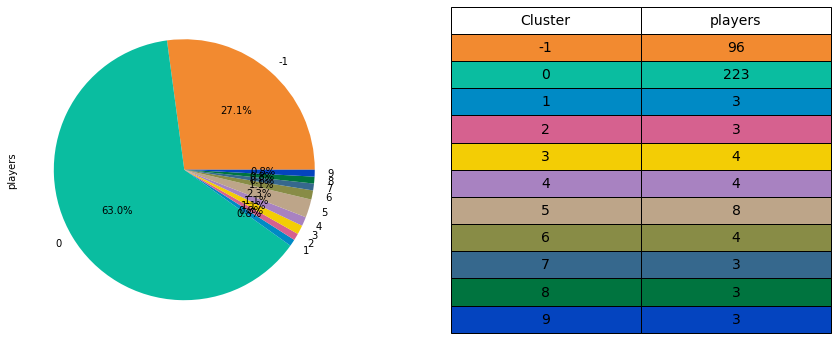


-----------------------
PLAYERS IN EACH CLUSTER
-----------------------



,-1,0,1,2,3,4,5,6,7,8,9
0,MS Dhoni,Umar Akmal,Mohammad Ashraful,AD Hales,ST Jayasuriya,Rameez Shahzad,LD Chandimal,IR Bell,BJ Haddin,RP Arnold,JH Kallis
1,KC Sangakkara,RS Bopara,V Sibanda,Fakhar Zaman,JJ Roy,Afif Hossain,PD Collingwood,KS Williamson,MDKJ Perera,AC Voges,SPD Smith
2,TM Dilshan,D Ramdin,CJ Chibhabha,Soumya Sarkar,AC Gilchrist,MW Machan,SC Williams,GC Smith,HH Gibbs,RK Paudel,SD Hope
3,V Kohli,TWM Latham,,,JM Bairstow,Khurram Khan,HDRL Thirimanne,G Gambhir,,,
4,DPMD Jayawardene,CR Ervine,,,,,S Chanderpaul,,,,
5,RG Sharma,A Symonds,,,,,RR Sarwan,,,,
6,Tamim Iqbal,AM Rahane,,,,,R Dravid,,,,
7,LRPL Taylor,GJ Bailey,,,,,Rahmat Shah,,,,
8,WU Tharanga,MS Wade,,,,,,,,,
9,AB de Villiers,BKG Mendis,,,,,,,,,


In [25]:
dbscan()